In [3]:
# pip install pytesseract
# pip install pdf2image
# pip install opencv-python
# pip install Pillow

In [1]:
from pdf2image import pdfinfo_from_path,convert_from_path
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [ ]:
#This part of the code helps convert the pdf's into page images

pdf_file = "Boskalis_Sustainability_Report_2020.pdf"
info = pdfinfo_from_path(pdf_file, userpw=None, poppler_path=None)

maxPages = info["Pages"]
pages = []
for page in range(1, maxPages+1, 10) :
    pages.append(convert_from_path(pdf_file, dpi=300, first_page=page, last_page = min(page+10-1,maxPages)))
    

i = 1 
for j in range(len(pages)):
    for page in pages[j]:
        image_name = "Page_" + str(i) + ".jpg"  
        page.save(image_name, "JPEG")
        i = i+1 

In [2]:
#working with one of the images

image_file = "./image/Page_5.jpg"
img = cv2.imread(image_file)


#Display Images
#https://stackoverflow.com/questions/28816046/
#displaying-different-images-with-actual-size-in-matplotlib-subplot
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [ ]:
display(image_file)

In [3]:
inverted_image = cv2.bitwise_not(img)
cv2.imwrite("temp/inverted.jpg", inverted_image)

True

In [ ]:
display('temp/inverted.jpg')

In [4]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [5]:
gray_image = grayscale(img)
cv2.imwrite("temp/gray.jpg", gray_image)

True

In [ ]:
display("temp/gray.jpg")

In [6]:
thresh, im_bw = cv2.threshold(gray_image, 220, 230, cv2.THRESH_BINARY)
cv2.imwrite("temp/bw_image.jpg", im_bw)

True

In [ ]:
display("temp/bw_image.jpg")

In [7]:
def noise_removal(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

In [8]:
no_noise = noise_removal(im_bw)
cv2.imwrite("temp/no_noise.jpg", no_noise)

True

In [ ]:
display("temp/no_noise.jpg")

In [9]:
def thin_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

In [10]:
eroded_image = thin_font(no_noise)
cv2.imwrite("temp/eroded_image.jpg", eroded_image)

True

In [ ]:
display("temp/eroded_image.jpg")

In [28]:
#The original image without preprocessing

ocr_result = pytesseract.image_to_string(img)

In [29]:
print (ocr_result)

| SUSTAINABILITY REPORT 2020 - BOSKALIS

 

CHAIRMAN’S
STATEMENT

The year 2020 has been exceptional in many ways.
At the beginning of March we presented our new
Corporate Business Plan for 2020-2022 and were
confident that the upward trend we had signaled
would continue. We were also positive about the
longer term as we expect Boskalis to make a
relevant contribution to solutions for the challenges
of the future, in the fields of infrastructure, the
energy transition and the protection of coastal
regions from the impact of climate change.
Sustainability would continue to be a main driver
in delivering these solutions.

Shortly thereafter, the magnitude of the COVID-19 pandemic
became apparent. Lockdown measures were announced across the
globe, working from home became the norm, the aviation industry
came to a grinding halt and as a consequence, keeping our
projects and vessels around the world operational and staffed
became an unprecedented challenge.

The welfare of our employees was

In [ ]:
#The preprocessed image
no_noise = "temp/no_noise.jpg"

In [32]:
img = Image.open(no_noise)

ocr_result = pytesseract.image_to_string(img)

In [33]:
print(ocr_result)

| SUSTAINABILITY REPORT 2020 - BOSKALIS

 

CHAIRMAN’S
STATEMENT

The year 2020 has been exceptional in many ways.
At the beginning of March we presented our new
Corporate Business Plan for 2020-2022 and were
confident that the upward trend we had signaled
would continue. We were also positive about the
longer term as we expect Boskalis to make a
relevant contribution to solutions for the challenges
of the future, in the fields of infrastructure, the
energy transition and the protection of coastal
regions from the impact of climate change.
Sustainability would continue to be a main driver
in delivering these solutions.

Shortly thereafter, the magnitude of the COVID-19 pandemic
became apparent. Lockdown measures were announced across the
globe, working from home became the norm, the aviation industry
came to a grinding halt and as a consequence, keeping our
projects and vessels around the world operational and staffed
became an unprecedented challenge.

The welfare of our employees was

In [3]:
def mark_region(image_path):
    
    im = cv2.imread(image_path)

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9,9), 0)
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,30)

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    dilate = cv2.dilate(thresh, kernel, iterations=4)

    # Find contours, highlight text areas, and extract ROIs
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    line_items_coordinates = []
    for c in cnts:
        area = cv2.contourArea(c)
        x,y,w,h = cv2.boundingRect(c)

        if y >= 600 and x <= 1000:
            if area > 10000:
                image = cv2.rectangle(im, (x,y), (2200, y+h), color=(255,0,255), thickness=3)
                line_items_coordinates.append([(x,y), (2200, y+h)])

        if y >= 2400 and x<= 2000:
            image = cv2.rectangle(im, (x,y), (2200, y+h), color=(255,0,255), thickness=3)
            line_items_coordinates.append([(x,y), (2200, y+h)])


    return image, line_items_coordinates

In [8]:
mark_region('./image/Page_1.jpg')

(array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

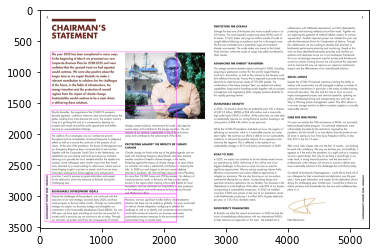

In [9]:

b, line_items_coordinates = mark_region('./image/Page_5.jpg')

plt.imshow(b)

2020 or www.boskalis.com.
ee po



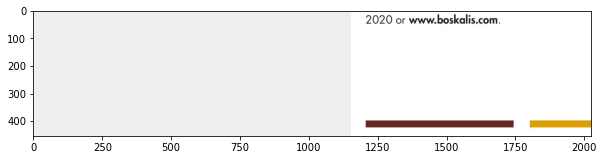

In [10]:
import pytesseract
pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'

# load the original image
image = cv2.imread('./image/Page_7.jpg')

# get co-ordinates to crop the image
c = line_items_coordinates[1]

# cropping image img = image[y0:y1, x0:x1]
img = image[c[0][1]:c[1][1], c[0][0]:c[1][0]]    

plt.figure(figsize=(10,10))
plt.imshow(img)

# convert the image to black and white for better OCR
ret,thresh1 = cv2.threshold(img,120,255,cv2.THRESH_BINARY)

# pytesseract image to string to get results
text = str(pytesseract.image_to_string(thresh1, config='--psm 6'))
print(text)